In [2]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from response import noisify
from tqdm import tqdm_notebook as tqdm
from adafilt import FastBlockLMSFilter, LMSFilter
from adafilt.io import FakeInterface
from adafilt.utils import lfilter, wgn

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
length = 16
stepsizes = np.logspace(-1, 0, 3)
navg = 100
snr = 20
# primary path impulse response
h_pri = [0, 0, 0, 0, 1]
# secondary path impulse response
h_sec = np.array([0, 0, 1])
nsamples = 1024

## LMSFilter

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")

        filt = LMSFilter(length, stepsize=stepsize)

        y, _, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend()

## LMSFilter with reference

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")

        filt = LMSFilter(length, stepsize=stepsize)

        y, u, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter

In [ ]:
blocklength = length
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")
        filt = FastBlockLMSFilter(blocklength, length, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter with reference

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")
        filt = FastBlockLMSFilter(length, blocklength, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FakeInterface

Test

In [ ]:
#np.random.seed(0)
buffsize = 1
buffers = 100
signal = np.random.normal(0, 1, size=buffers * buffsize * 2)
sim = FakeInterface(buffsize, signal, h_pri=[0, 1], h_sec=[1])

xs = []
es = []

x = np.array([0])
for i in range(10):
    x, e, u, d = sim.playrec(x)
    xs.append(x)
    es.append(e)

plt.plot(xs)
plt.plot(es)

Measure primary and secondary path

In [ ]:
buffsize = 1
buffers = 1000
h_pri = [0, 1]
h_sec = [1]
sim = FakeInterface(
    buffsize,
    np.random.normal(0, 1, size=buffers * buffsize),
    h_pri=h_pri,
    h_sec=h_sec,
)

# measure primary path
xs = []
es = []
for i in range(buffers):
    x, e, _, _ = sim.rec()
    xs.append(x)
    es.append(e)
    
xs = np.concatenate(xs)
es = np.concatenate(es)
h_pri_meas = np.fft.irfft(np.fft.rfft(es) / np.fft.rfft(xs))[:10]

# measure secondary path
sim.reset()
ys = []
us = []
for i in range(buffers):
    y = np.random.normal(0, 1, size=buffsize)
    _, e, _, _ = sim.playrec(y, send_signal=False)
    ys.append(y)
    us.append(-e)

ys = np.concatenate(ys)
us = np.concatenate(us)
h_sec_meas = np.fft.irfft(np.fft.rfft(us) / np.fft.rfft(ys))[:10]

plt.plot(h_pri_meas, label="pri")
plt.plot(h_sec_meas, label="sec")
plt.legend()


### Sample based FxLMS

V1 usign adapt and filt

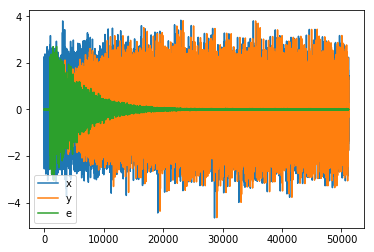

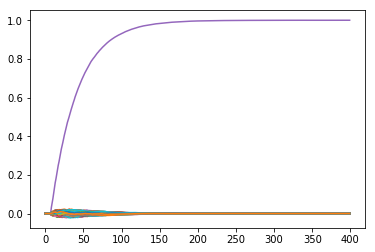

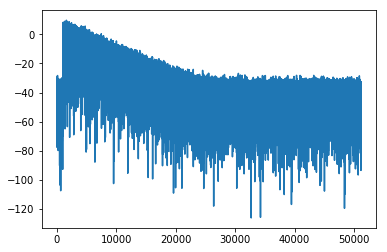

In [5]:
np.set_printoptions(precision=2)
np.random.seed(0)

h_pri = np.zeros(1024)
h_pri[-1] = 1
h_sec = np.zeros(512)
h_sec[-1] = 1

blocklength = 128
length = 512

# random signal
Nbuffs = 400
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = LMSFilter(length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
fxbuff = deque(np.zeros(length), maxlen=length)
xbuff = deque(np.zeros(length), maxlen=length)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)
    fx, zisec = lfilter(h_sec_model, 1, x, zi=zisec)
    for i in range(blocklength):
        filt.adapt(fx[i], e[i])
        y[i] = filt.filt(x[i])
    
    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


### FastBlockFxLMS sistepsizelation with variable block size

Some necessary conditions for convergence

In [ ]:
assert blocklength <= len(h_sec)
assert blocklength <= len(h_pri) - len(h_sec)
assert length > len(h_pri) - len(h_sec) - blocklength

#### Buffersize == filtersize

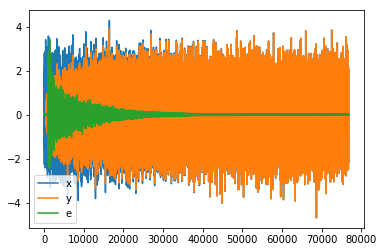

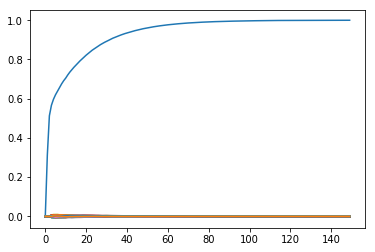

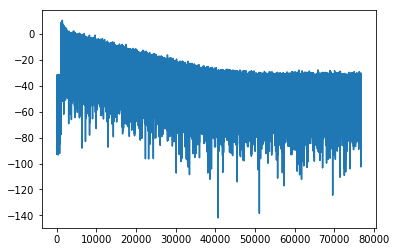

In [6]:
blocklength = 512
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(blocklength, length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = lfilter(h_sec_model, 1, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


#### Buffersize < filtersize

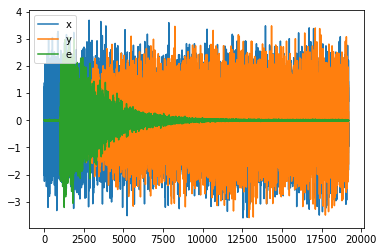

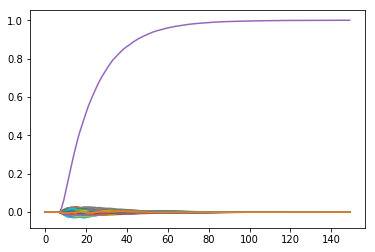

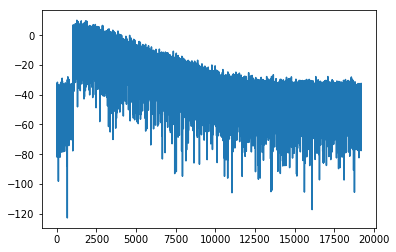

In [7]:
blocklength = 128
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(length, blocklength)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = lfilter(h_sec_model, 1, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))
